In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from anndata.experimental.multi_files import AnnCollection
import anndata as ad
from scipy import sparse
from scipy.io import mmwrite
from scipy.io import mmread
from scipy.stats import zscore
import pyarrow.parquet as pq

/bgfs/rgottschalk/Sonia/envs/celloracle_new/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
#load scRNAseq data (filtered for just AMs)
AMrawpath = '20250304_GSE280003_allAM_expression_table.parquet'
AMpd = pd.read_parquet(AMrawpath)
AMpd = AMpd.T.astype('float64')
AMpd

,AAACCCAAGAGAGCGG-1_GSM8585457,AAACCCAAGGTTACAA-1_GSM8585457,AAACCCATCCCAGCGA-1_GSM8585457,AAACGAACAAGTATAG-1_GSM8585457,AAACGAATCGCTGTCT-1_GSM8585457,AAACGCTAGATGCTGG-1_GSM8585457,AAACGCTCAGGAACCA-1_GSM8585457,AAAGAACAGTAACCTC-1_GSM8585457,AAAGAACTCTGCATAG-1_GSM8585457,AAAGGGCCAGGTAGTG-1_GSM8585457,...,TTTGACTGTCTGTGTA-1_GSM8585430,TTTGACTGTGTGGACA-1_GSM8585430,TTTGACTTCAAGTGGG-1_GSM8585430,TTTGATCAGGACTTCT-1_GSM8585430,TTTGATCCAGTCAGCC-1_GSM8585430,TTTGATCGTAGTCGTT-1_GSM8585430,TTTGATCGTTGTATGC-1_GSM8585430,TTTGGAGAGAAGGATG-1_GSM8585430,TTTGGTTCATGGGTTT-1_GSM8585430,TTTGGTTTCTTGAACG-1_GSM8585430
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC149090.1,0.0,1.0,0.0,1.0,1.0,0.0,9.0,1.0,2.0,1.0,...,4.0,4.0,0.0,2.0,1.0,3.0,0.0,3.0,1.0,0.0
CAAA01118383.1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
Vmn2r122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#subset for the identified MoM and RAM barcoded cells
MoM_barcodes_path = 'topicModeling/20251024_clust3_MoM_barcodes.csv'
RAM_barcodes_path = 'topicModeling/20251024_clust4_RAM_barcodes.csv'
MoM_barcodes = pd.read_csv(MoM_barcodes_path)
RAM_barcodes = pd.read_csv(RAM_barcodes_path)
MoMdf = AMpd.loc[:, MoM_barcodes.loc[:,'x']]
RAMdf = AMpd.loc[:,RAM_barcodes.loc[:,'x']]
MoMdf

,AAACCCAAGAGAGCGG-1_GSM8585457,AAACCCATCCCAGCGA-1_GSM8585457,AAACGAACAAGTATAG-1_GSM8585457,AAACGAATCGCTGTCT-1_GSM8585457,AAACGCTAGATGCTGG-1_GSM8585457,AAAGGGCGTGGAGGTT-1_GSM8585457,AAAGGGCTCAGCAATC-1_GSM8585457,AAAGGTACACTTGAAC-1_GSM8585457,AAAGTGAGTCACGCTG-1_GSM8585457,AACAAAGCATTGGATC-1_GSM8585457,...,TTTCGATCAAGCCCAC-1_GSM8585430,TTTCGATCAAGGGCAT-1_GSM8585430,TTTGACTGTATCAGGG-1_GSM8585430,TTTGACTGTCTGTGTA-1_GSM8585430,TTTGACTGTGTGGACA-1_GSM8585430,TTTGATCAGGACTTCT-1_GSM8585430,TTTGATCGTAGTCGTT-1_GSM8585430,TTTGATCGTTGTATGC-1_GSM8585430,TTTGGAGAGAAGGATG-1_GSM8585430,TTTGGTTTCTTGAACG-1_GSM8585430
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC149090.1,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,4.0,4.0,2.0,3.0,0.0,3.0,0.0
CAAA01118383.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0
Vmn2r122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#match barcodes to sample conditions
sample_dict = {'GSM8585447': 'LPS_D06_AM_rep3', 'GSM8585445':'LPS_D06_AM_rep1', 'GSM8585433' :'LPS_D03_AM_rep4', 
               'GSM8585432':'LPS_D03_AM_rep3', 'GSM8585430' : 'LPS_D03_AM_rep1', 'GSM8585457':'LPS_D15_AM_rep1',
               'GSM8585418': 'Homeostasis_D00_AM_rep1', 'GSM8585458':'LPS_D15_AM_rep2', 'GSM8585419':'Homeostasis_D00_AM_rep2',
               'GSM8585420':'Homeostasis_D00_AM_rep3', 'GSM8585446':'LPS_D06_AM_rep2', 'GSM8585431':'LPS_D03_AM_rep2'}
sample_dict_simple = {'GSM8585447': 'LPS_D06', 'GSM8585445':'LPS_D06', 'GSM8585433' :'LPS_D03', 
               'GSM8585432':'LPS_D03', 'GSM8585430' : 'LPS_D03', 'GSM8585457':'LPS_D15',
               'GSM8585418': 'Homeostasis_D00', 'GSM8585458':'LPS_D15', 'GSM8585419':'Homeostasis_D00',
               'GSM8585420':'Homeostasis_D00', 'GSM8585446':'LPS_D06', 'GSM8585431':'LPS_D03'}
def matchBarcodes(ind, d):
    new = dict()
    for i in ind:
        sampid = i[-10:]
        desc = d[sampid]
        new[i] = desc
    return new

MoM_barcodes_dict = matchBarcodes(MoMdf.columns, sample_dict_simple)
RAM_barcodes_dict = matchBarcodes(RAMdf.columns, sample_dict_simple)
MoM_simp_labs = MoMdf.copy().rename(columns = MoM_barcodes_dict)
RAM_simp_labs = RAMdf.copy().rename(columns = RAM_barcodes_dict)

#create pseudobulk
ordered_cols = ['Homeostasis_D00', 'LPS_D03','LPS_D06', 'LPS_D15']
def pseudobulk_scdata(simp_labs, order = ordered_cols):
    newcols = dict()
    for t in ordered_cols:
        curr = simp_labs[t].agg('sum', axis=1)
        num = len(simp_labs[t].columns)
        newcols[t] = curr/num
    pseudoblk = pd.DataFrame(newcols)
    return pseudoblk
MoM_psblk = pseudobulk_scdata(MoM_simp_labs).T
RAM_psblk = pseudobulk_scdata(RAM_simp_labs).T
MoMind = pd.MultiIndex.from_arrays([['MoM'] * len(MoM_psblk), MoM_psblk.index], names=('CellType', 'Time'))
MoM_psblk.index = MoMind
RAMind = pd.MultiIndex.from_arrays([['RAM'] * len(RAM_psblk), RAM_psblk.index], names=('CellType', 'Time'))
RAM_psblk.index = RAMind

#pseudobulk_scdata(MoM_simp_labs).to_csv('20251113_MoM_GSE280003_psblk.csv')
#pseudobulk_scdata(RAM_simp_labs).to_csv('20251113_RAM_GSE280003_psblk.csv')

In [6]:
all_psblk = pd.concat([RAM_psblk, MoM_psblk])
all_psblk = all_psblk.reset_index()
all_psblk

,CellType,Time,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,RAM,Homeostasis_D00,0.00000,0.0,0.0,0.001071,0.014222,0.0,0.656217,1.018199,...,0.000000,0.000153,0.0,0.0,0.000153,0.003364,1.211653,0.486313,0.0,0.018351
1,RAM,LPS_D03,0.00000,0.0,0.0,0.000000,0.008419,0.0,1.389056,2.085989,...,0.000000,0.000000,0.0,0.0,0.000601,0.009020,1.146121,0.827420,0.0,0.049308
2,RAM,LPS_D06,0.00000,0.0,0.0,0.000000,0.018950,0.0,0.630321,1.153936,...,0.000000,0.000875,0.0,0.0,0.000875,0.009038,1.432653,0.486006,0.0,0.018076
3,RAM,LPS_D15,0.00043,0.0,0.0,0.000430,0.011168,0.0,0.812715,1.257302,...,0.000000,0.000000,0.0,0.0,0.000000,0.021907,1.385739,0.579897,0.0,0.024055
4,MoM,Homeostasis_D00,0.00000,0.0,0.0,0.000000,0.007018,0.0,0.287719,0.277193,...,0.000000,0.000000,0.0,0.0,0.000000,0.021053,0.705263,0.263158,0.0,0.038596
5,MoM,LPS_D03,0.00000,0.0,0.0,0.000772,0.010037,0.0,1.339870,0.976220,...,0.000154,0.001853,0.0,0.0,0.001235,0.009883,2.018684,0.738419,0.0,0.079216
6,MoM,LPS_D06,0.00000,0.0,0.0,0.000421,0.013901,0.0,0.919966,0.975147,...,0.000000,0.003370,0.0,0.0,0.000421,0.005897,3.985257,0.742628,0.0,0.077085
7,MoM,LPS_D15,0.00000,0.0,0.0,0.002413,0.015682,0.0,0.648975,0.512666,...,0.000000,0.000000,0.0,0.0,0.003619,0.000000,1.844391,0.482509,0.0,0.048251


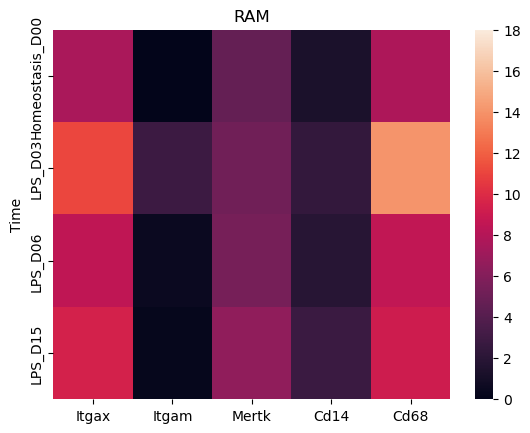

In [63]:
def makeHeatmap(df, celltype, GoIs, minv = 0, maxv = 20, title='', cmap='rocket'):
    GoIs.add('CellType')
    GoIs.add('Time')
    current = df.loc[:, list(GoIs)]
    current = current.reset_index().query('CellType == @celltype').drop(['CellType'], axis=1).set_index('Time')
    sns.heatmap(current[['Itgax', 'Itgam','Mertk','Cd14','Cd68']], vmin=minv, vmax=maxv, cmap=cmap)
    plt.title(title)
    return current

r = makeHeatmap(all_psblk, 'RAM', GoI, maxv=18, title='RAM')
plt.savefig('20260109_RAM_gene_heatmap.pdf')

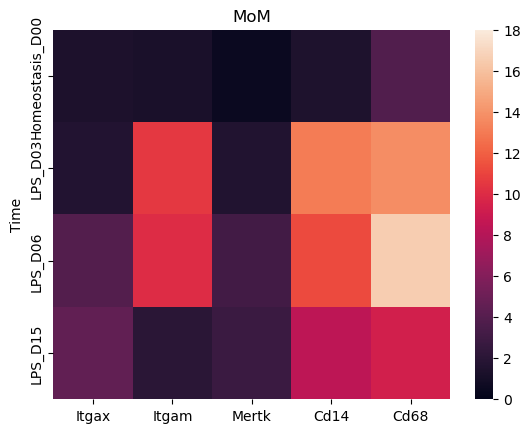

In [64]:
m = makeHeatmap(all_psblk, 'MoM', GoI, maxv=18, title='MoM')
plt.savefig('20260109_MoM_gene_heatmap.pdf')

In [24]:
df = all_psblk.copy()
df['label'] = df[df.columns[0:2]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
df = df.drop(['CellType','Time'], axis=1).T
df = df.rename(columns = dict(zip(df.columns, df.loc['label']))).drop('label')

In [5]:
MoMdf2 = MoMdf.copy().T
RAMdf2 = RAMdf.copy().T
MoMdf2['type'] = ['MoM'] * len(MoMdf2)
RAMdf2['type'] = ['RAM'] * len(RAMdf2)
allsc = pd.concat([MoMdf2.T, RAMdf2.T], axis=1)
allsc_barcodes_dict = matchBarcodes(allsc.columns, sample_dict_simple)
allsc

,AAACCCAAGAGAGCGG-1_GSM8585457,AAACCCATCCCAGCGA-1_GSM8585457,AAACGAACAAGTATAG-1_GSM8585457,AAACGAATCGCTGTCT-1_GSM8585457,AAACGCTAGATGCTGG-1_GSM8585457,AAAGGGCGTGGAGGTT-1_GSM8585457,AAAGGGCTCAGCAATC-1_GSM8585457,AAAGGTACACTTGAAC-1_GSM8585457,AAAGTGAGTCACGCTG-1_GSM8585457,AACAAAGCATTGGATC-1_GSM8585457,...,TAACTTCTCAGCGGAA-1_GSM8585430,TAGGTACTCCTTATGT-1_GSM8585430,TCAATCTCACTGTGTA-1_GSM8585430,TCACGCTGTTCGTACA-1_GSM8585430,TCCGAAACAGGTCCCA-1_GSM8585430,TCTACATAGCTTCATG-1_GSM8585430,TTACTGTGTTACCCTC-1_GSM8585430,TTCCTTCAGTGATCGG-1_GSM8585430,TTTAGTCCAAATGCGG-1_GSM8585430,TTTGATCCAGTCAGCC-1_GSM8585430
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC149090.1,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
CAAA01118383.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0
Vmn2r122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAA01147332.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
temp = allsc.T
temp = temp.reset_index()
temp['uniqueLab'] = temp['index'].astype(str).apply(lambda x: allsc_barcodes_dict[x])
temp['uniqueLab'] = temp['uniqueLab'].astype(str) + '_' + temp['type'].astype(str)
temp = temp.set_index('index')
typelabs = temp.pop('type')
uniquelabs = temp.pop('uniqueLab')
allsc = temp.T
allsc

index,AAACCCAAGAGAGCGG-1_GSM8585457,AAACCCATCCCAGCGA-1_GSM8585457,AAACGAACAAGTATAG-1_GSM8585457,AAACGAATCGCTGTCT-1_GSM8585457,AAACGCTAGATGCTGG-1_GSM8585457,AAAGGGCGTGGAGGTT-1_GSM8585457,AAAGGGCTCAGCAATC-1_GSM8585457,AAAGGTACACTTGAAC-1_GSM8585457,AAAGTGAGTCACGCTG-1_GSM8585457,AACAAAGCATTGGATC-1_GSM8585457,...,TAACTTCTCAGCGGAA-1_GSM8585430,TAGGTACTCCTTATGT-1_GSM8585430,TCAATCTCACTGTGTA-1_GSM8585430,TCACGCTGTTCGTACA-1_GSM8585430,TCCGAAACAGGTCCCA-1_GSM8585430,TCTACATAGCTTCATG-1_GSM8585430,TTACTGTGTTACCCTC-1_GSM8585430,TTCCTTCAGTGATCGG-1_GSM8585430,TTTAGTCCAAATGCGG-1_GSM8585430,TTTGATCCAGTCAGCC-1_GSM8585430
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC149090.1,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
CAAA01118383.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0
Vmn2r122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
AMmtx = allsc.T.astype('float64').to_numpy()
adata = ad.AnnData(AMmtx)
adata.var_names = allsc.T.columns
adata.obs_names = allsc.columns
adata.obs['time'] = allsc_barcodes_dict
adata.obs['macType'] = typelabs
adata.obs['unique'] = uniquelabs
adata.obs

,time,macType,unique
index,,,
AAACCCAAGAGAGCGG-1_GSM8585457,LPS_D15,MoM,LPS_D15_MoM
AAACCCATCCCAGCGA-1_GSM8585457,LPS_D15,MoM,LPS_D15_MoM
AAACGAACAAGTATAG-1_GSM8585457,LPS_D15,MoM,LPS_D15_MoM
AAACGAATCGCTGTCT-1_GSM8585457,LPS_D15,MoM,LPS_D15_MoM
AAACGCTAGATGCTGG-1_GSM8585457,LPS_D15,MoM,LPS_D15_MoM
...,...,...,...
TCTACATAGCTTCATG-1_GSM8585430,LPS_D03,RAM,LPS_D03_RAM
TTACTGTGTTACCCTC-1_GSM8585430,LPS_D03,RAM,LPS_D03_RAM
TTCCTTCAGTGATCGG-1_GSM8585430,LPS_D03,RAM,LPS_D03_RAM


In [15]:
#subset for genes with nonzero variance
nonzero_var = adata.X.var(axis=0) > 0
adata = adata[:, nonzero_var].copy()

AnnData object with n_obs × n_vars = 23924 × 20976
    obs: 'time', 'macType', 'unique'

/bgfs/rgottschalk/Sonia/envs/celloracle/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


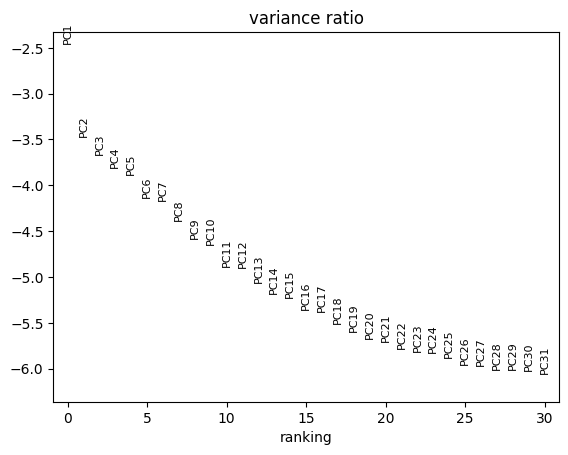

In [62]:
#for making a umap, skip otherwise
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize counts per cell
sc.pp.log1p(adata)  # Log-transform
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]  # Subset to highly variable genes
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata, log=True)  # Check variance explained

/bgfs/rgottschalk/Sonia/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


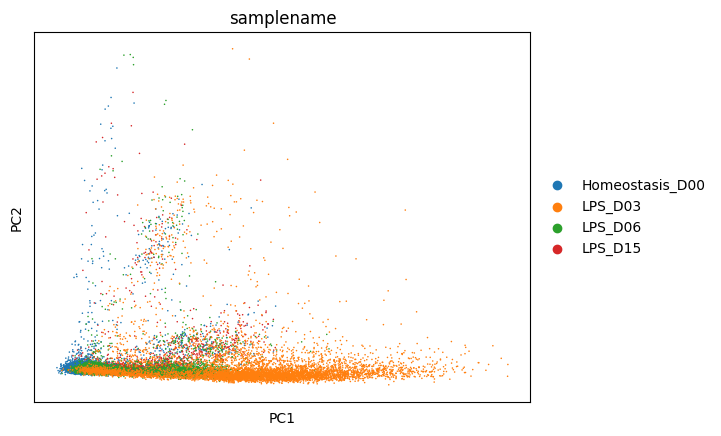

In [95]:
sc.tl.pca(adata, n_comps=2, svd_solver='arpack')
sc.pl.pca(adata, color = 'samplename')

In [29]:
# get gene loadings for PC1
loadings = pd.DataFrame(adata.varm['PCs'][:,0], index=adata.var_names, columns=['PC1_loading'])
loadings.abs().sort_values('PC1_loading', ascending=False).head(20)

,PC1_loading
Laptm5,0.031449
Cd44,0.029984
Abcg1,0.029497
Mpeg1,0.029427
Lcp1,0.029417
Sirpa,0.029218
Nceh1,0.029113
Axl,0.028579
Msrb1,0.028563
Reep5,0.028562


/bgfs/rgottschalk/Sonia/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


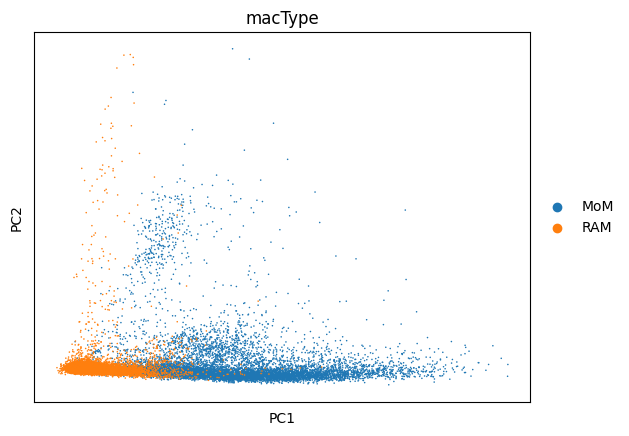

In [96]:
sc.pl.pca(adata, color = 'macType')

/bgfs/rgottschalk/Sonia/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


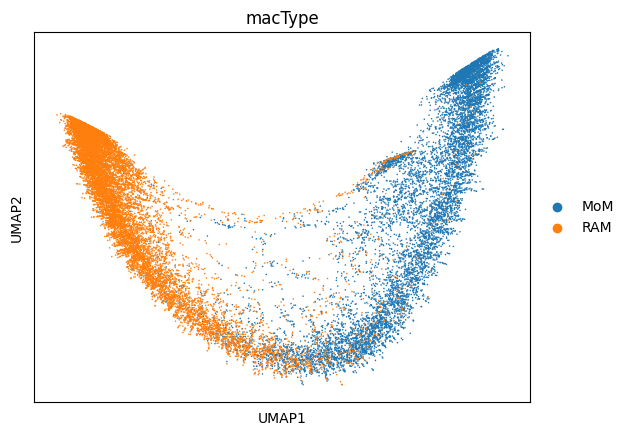

In [97]:
sc.pp.neighbors(adata, use_rep='X_pca',n_neighbors=15, n_pcs=6)  # Adjust `n_pcs` based on PCA plot
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color="macType")

/bgfs/rgottschalk/Sonia/envs/celloracle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


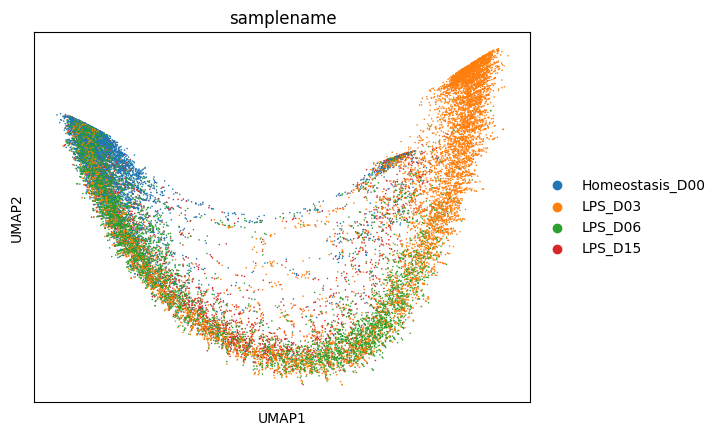

In [98]:
sc.pl.umap(adata, color='samplename')

In [16]:
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

/scratch/slurm-6861760/ipykernel_3955966/2380050727.py:2: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = sc.pp.filter_genes_dispersion(adata.X,
/ihome/djishnu/aaf92/.conda/envs/celloracle_env2/lib/python3.11/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:211: RuntimeWarning: divide by zero encountered in divide
  np.abs(
/ihome/djishnu/aaf92/.conda/envs/celloracle_env2/lib/python3.11/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:211: RuntimeWarning: invalid value encountered in divide
  np.abs(


In [18]:
#load TFs
f =  open('TFs.txt', 'r')
AM_proteomic_TF = set()
for line in f:
    AM_proteomic_TF.add(f.readline().strip())
f.close()

In [20]:
# Subset the genes

adata1 = adata[:, filter_result.gene_subset]
adata_TFs = adata[:, list(AM_proteomic_TF.intersection(set(adata.var_names)).difference(adata1.var_names))]
adata = ad.concat([adata1,adata_TFs], axis = 1)
adata.obs['time'] = allsc_barcodes_dict
adata.obs['macType'] = typelabs.to_dict()
adata.obs['unique'] = uniquelabs.to_dict()

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

/scratch/slurm-6861760/ipykernel_3955966/1442135731.py:21: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata)
/ihome/djishnu/aaf92/.conda/envs/celloracle_env2/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:588: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


AnnData object with n_obs × n_vars = 23924 × 2381
    obs: 'time', 'macType', 'unique', 'n_counts'

In [21]:
# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [22]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(adata)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

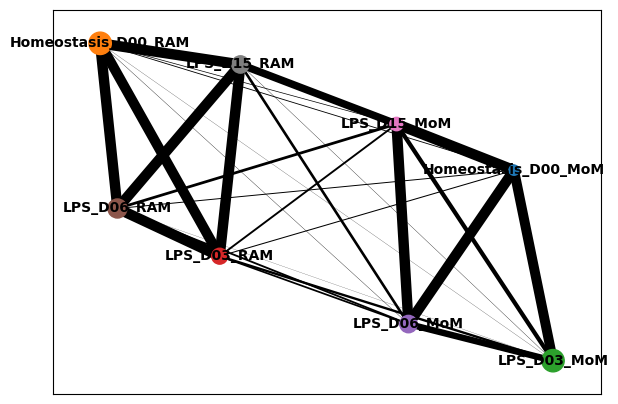

In [25]:
sc.tl.louvain(adata, flavor = 'igraph')
sc.tl.paga(adata, groups='unique')
sc.pl.paga(adata)

In [26]:
sc.tl.draw_graph(adata,init_pos='paga', random_state=123)

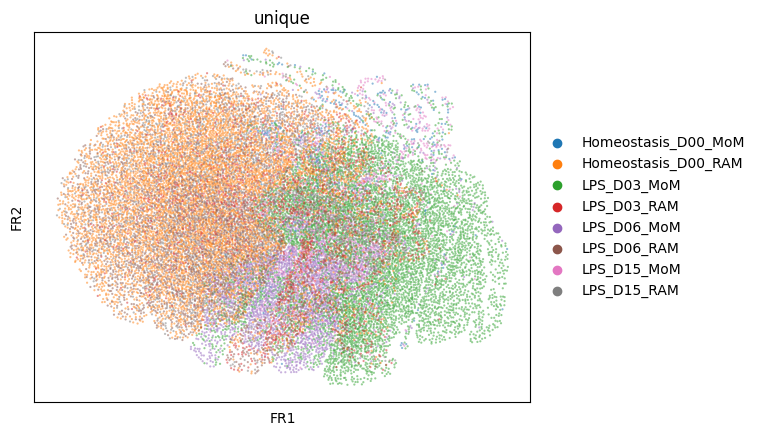

In [27]:
sc.pl.draw_graph(adata, color='unique', legend_loc='right margin', size=10, alpha=0.5)

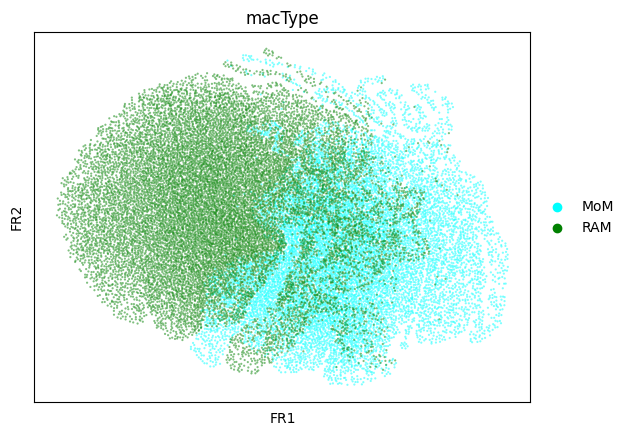

In [28]:
sc.pl.draw_graph(adata, color='macType', legend_loc='right margin', size=10, alpha=0.5, palette=['cyan', 'green'])

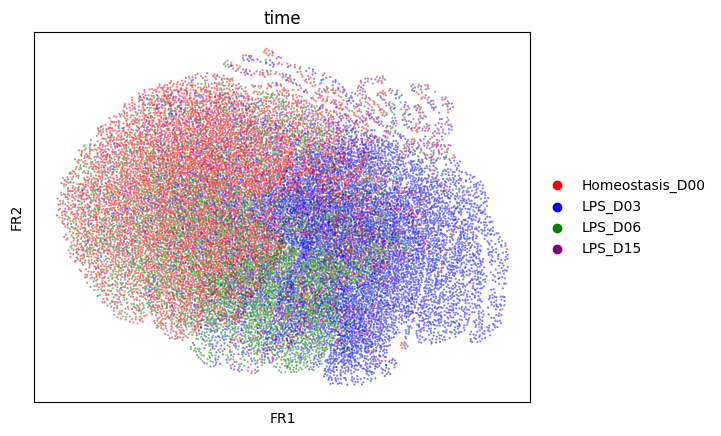

In [31]:
sc.pl.draw_graph(adata, color='time', legend_loc='right margin', size=10, alpha=0.5, palette = ['red', 'blue', 'green', 'purple'])

In [78]:
adata

AnnData object with n_obs × n_vars = 23924 × 2000
    obs: 'time', 'macType', 'unique', 'n_counts', 'louvain'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'louvain', 'paga', 'macType_sizes', 'macType_colors', 'unique_sizes', 'unique_colors', 'draw_graph'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [79]:
adata.write_h5ad("20251111_RAM_MoM_scRNAseq_GSE280003.h5ad")